In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scipy import stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)  

# Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data_link = 'https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/dev.csv'
df = pd.read_csv(raw_data_link, index_col=0) #using dev set

### 1. CASTING

In [10]:
#casting data types
def casting(df):
  df['NUM_UNITS'] = df['NUM_UNITS'].astype(pd.Int64Dtype())
  df['KITCHENS'] = df['KITCHENS'].astype(pd.Int64Dtype())
  df['USECODE'] = df['USECODE'].astype(pd.Int64Dtype()).astype('category')
  df['ZIPCODE'] = df['ZIPCODE'].astype(pd.Int64Dtype()).astype('category')
  df['CMPLX_NUM'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['CENSUS_TRACT'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])
  return df

In [11]:
df1 = casting(df)

### 2. QUALIFIED FEATURES 

The QUALIFIED feature is internally-used indicator to reflect if a sale is representative of market value according to the office's internal criteria. Since the 'U' means it does not reflect the market value, we will drop the 'U' value and QUALIFIED feature since it only contains 1 value of 'Q'.

In [12]:
def drop_qualified(df):
  df = df[df['QUALIFIED']=='Q']
  df = df.drop('QUALIFIED', axis=1)
  
  # print('Before removing unqualified:', df.shape)
  # print('After removing unqualified:', df_q.shape)
  
  return df

In [13]:
df2 = drop_qualified(df1)

In [15]:
print('Before removing unqualified:', df1.shape)
print('After removing unqualified:', df2.shape)

Before removing unqualified: (102661, 48)
After removing unqualified: (58192, 47)


### 3. MISSING DATA

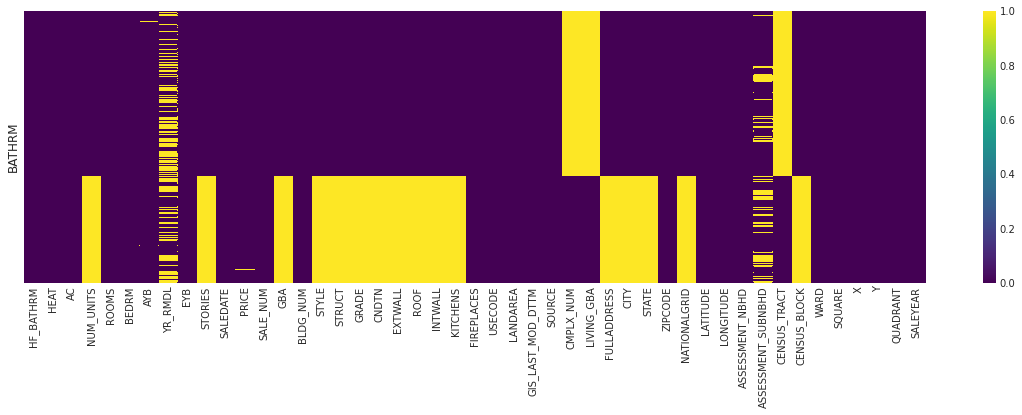

In [31]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df2.isnull(), yticklabels=False,cmap='viridis')
plt.show()

Since the missing values seems to have a pattern, we might want to dig deeper into the source (residential & condominium)

In [24]:
res = df2[df2['SOURCE']=='Residential']
con = df2[df2['SOURCE']=='Condominium']

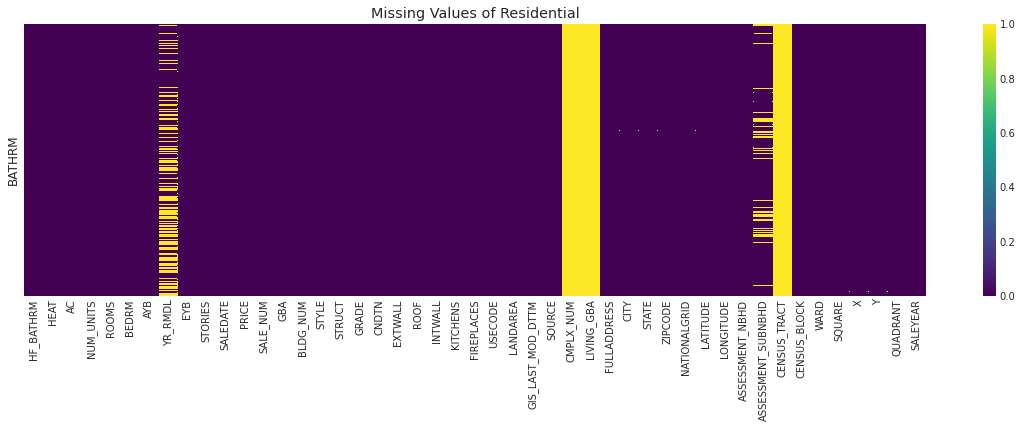

In [22]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(res.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

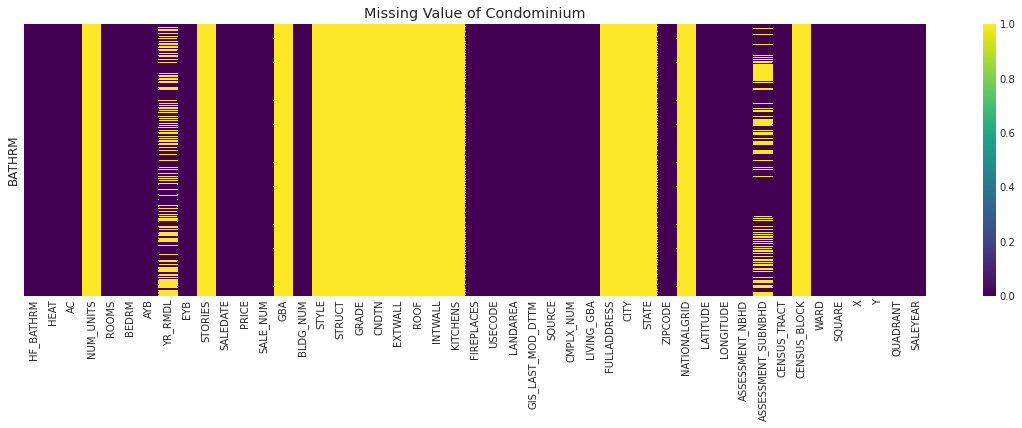

In [23]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(con.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Value of Condominium')
plt.show()

Clearly, they both have several different features. We assume that the price predictor model of residential and condominium will be different. The condominium data seems to have more missing value than the residential. In this case, we decide to build the price predictor of **residential**

In [25]:
df3 = res.copy()

Dropping unused features :
- CMPLX_NUM, LIVING_GBA, CENSUS_TRACT : only available in condominium data
- ASSESSMENT_SUBNBHD, FULLADDRESS,NATIONAL GRID, and CENSUS_BLOCK : high cardinality
- CITY, STATE : single value (Washington, DC)
- X, Y : same value with LONGITUDE and LATITUDE
- SALEDATE : replaced with SALEYEAR

In [29]:
df4 = df3.drop(['CMPLX_NUM','LIVING_GBA','CENSUS_TRACT','ASSESSMENT_SUBNBHD',
                'FULLADDRESS','NATIONALGRID','CENSUS_BLOCK','CITY','STATE',
                'X','Y','SALEDATE'],axis=1)

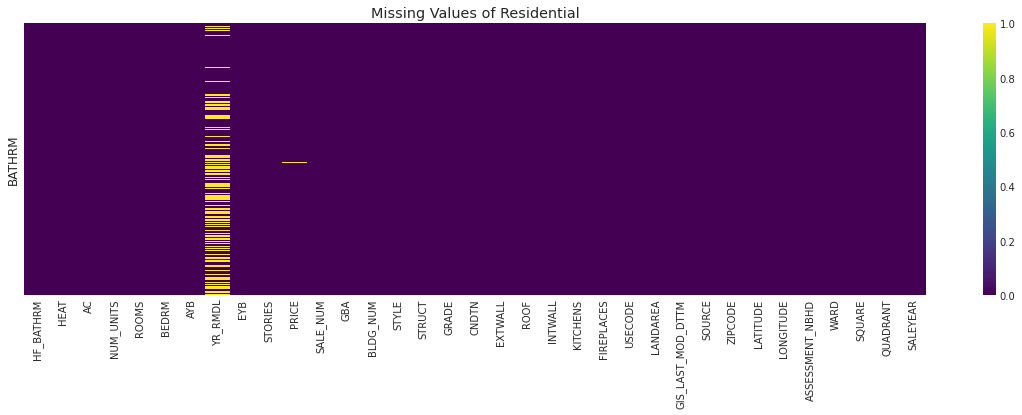

In [30]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df4.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

The YR_RMDL features seems too important to drop. Intuitively, whether the properties have been remodeled or not will affect the price. We decide to do feature engineering by converting the YR_RMDL to boolean (Y/N). Y means the property has been remodeled and vice versa

In [32]:
#feature engineering YR_RMDL
df5 = df4.copy()
df5['RMDL'] = np.where(df4['YR_RMDL'].isna(),0,1)
df5 = df5.drop('YR_RMDL',axis=1)

In [34]:
df5.shape

(35523, 35)

In [35]:
#drop remaining price missing values
df6 = df5.dropna()

In [36]:
df6.shape

(35311, 35)

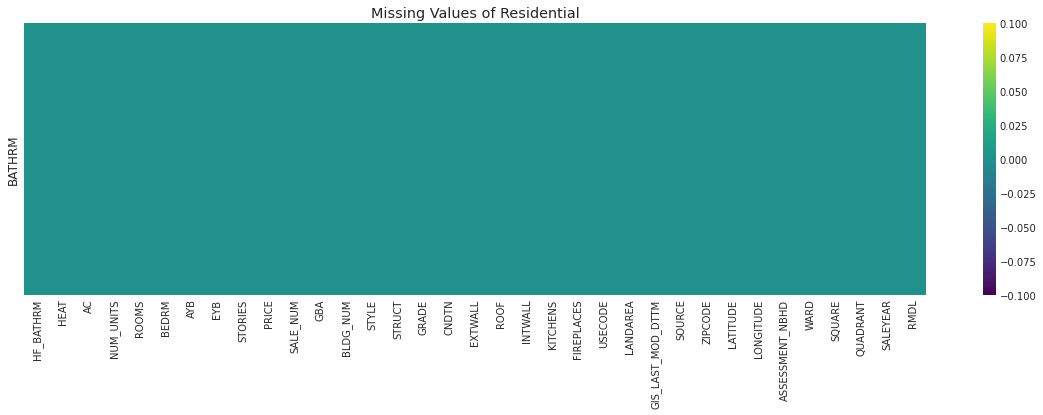

In [37]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df6.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

### 4. UNRELATED COLUMNS

some features do not related to the properties (update version date and source data)

In [38]:
df7 = df6.drop(['GIS_LAST_MOD_DTTM','SOURCE'],axis=1)

### 5. OUTLIERS

In [40]:
df7['AC'].value_counts()

Y    26809
N     8496
0        6
Name: AC, dtype: int64

In [42]:
df7['HEAT'].value_counts()

Forced Air        13196
Hot Water Rad     12058
Warm Cool          9317
Ht Pump             491
Water Base Brd       63
Elec Base Brd        46
Wall Furnace         42
Electric Rad         25
Gravity Furnac       23
Air-Oil              19
Evp Cool             10
Air Exchng            9
No Data               6
Ind Unit              6
Name: HEAT, dtype: int64

In [43]:
df8 = df7.copy()
df8['AC'] = np.where(df7['AC']=='Y',1,0) #convert to 1 0 

df8 = df8[df8['HEAT']!='No Data'] #delete no data

### 6. SIMILAR VALUES

- STORIES has similar values with STYLE. We keep STYLE since STORIES has many outliers due to mistyping.
- Location is represented by too many features. We want to keep one to be used as the feature.
  - WARD : keep
  - ZIPCODE, ASSESSMENT_NBHD, SQUARE : high cardinality
  - LONGLAT : 

In [ ]:
#df8 = df7.drop(['STORIES','ZIPCODE','ASSESSMENT_NBHD','SQUARE','LONGITUDE','LATITUDE'],axis=1)

In [45]:
df9 = df8.drop(['STORIES'],axis=1)

In [48]:
df9.shape

(35305, 32)

In [49]:
df9.columns

Index(['HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'EYB',
       'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE',
       'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES',
       'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'WARD', 'SQUARE', 'QUADRANT', 'SALEYEAR', 'RMDL'],
      dtype='object')

### 7. CORRELATION

CATEGORICAL (CRAMERS V)

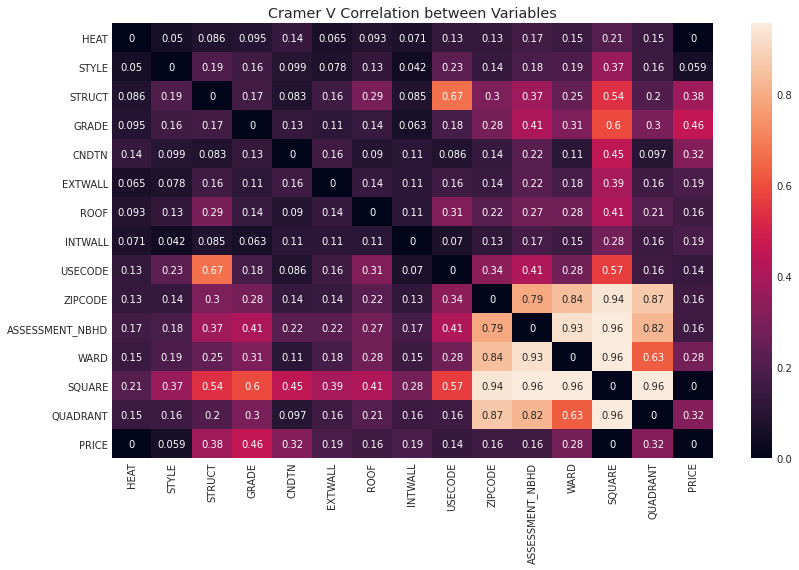

In [52]:
from itertools import combinations
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = ['HEAT','STYLE','STRUCT', 'GRADE', 'CNDTN', 'EXTWALL','ROOF', 'INTWALL','USECODE','ZIPCODE','ASSESSMENT_NBHD','WARD','SQUARE','QUADRANT','PRICE']
# fitur kategorikal yang diambil yang sekiranya dapat di korelasikan dengan 'Price', kategori geographical yang diambil hanya yang mempunyai distinct data yg kecil
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df9[col1], df9[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");


The location features seems to have interaction with each other. Based on multiple trial on the model, we decide to take only WARD, since it is one of the top feature importance according to our model

We also want to drop LONGLAT since it is already represented by the WARD

In [54]:
df9.columns

Index(['HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'EYB',
       'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE',
       'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES',
       'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'WARD', 'SQUARE', 'QUADRANT', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [55]:
df10 = df9.drop(['ZIPCODE','ASSESSMENT_NBHD','SQUARE','QUADRANT','LATITUDE','LONGITUDE'],axis=1)

NUMERICAL

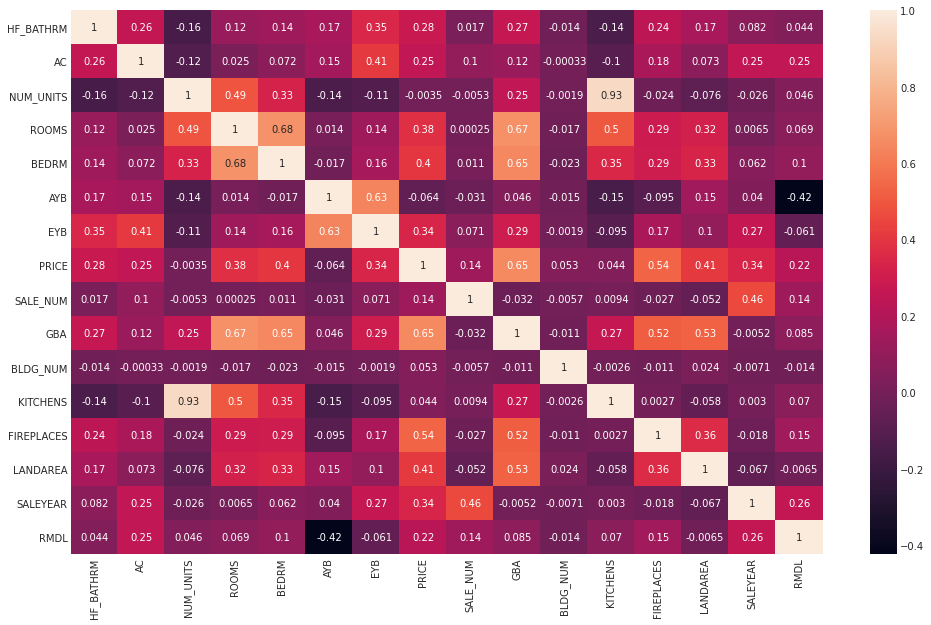

In [56]:
plt.figure(figsize=(15,10))
sns.heatmap(df10.corr(), annot=True)
plt.show()

Some multicollinearity occurs between :
  - NUM_UNITS vs KITCHENS

Weak correlation :
 - BLDG_NUM

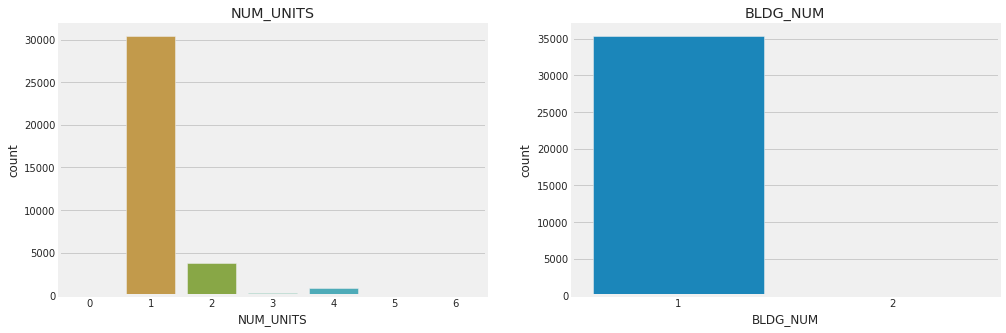

In [62]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(df10['NUM_UNITS'], ax=ax[0]).set_title('NUM_UNITS')
sns.countplot(df10['BLDG_NUM'], ax=ax[1]).set_title('BLDG_NUM')
plt.show()

Since both of the feature has imbalanced values and is not considered important based on our model trial, we decide to drop both features

In [63]:
df11 = df10.drop(['NUM_UNITS','BLDG_NUM'],axis=1)

In [64]:
df11.shape

(35305, 24)

### 9. ENCODING

In [65]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [66]:
import category_encoders as ce

In [67]:
ordinal_mapping = [{'col':'CNDTN','mapping':{'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5,'Excellent':6}}]
ordinal_encoder = ce.OrdinalEncoder(cols ='CNDTN',mapping = ordinal_mapping) 
df12 = ordinal_encoder.fit_transform(df11)                                                

In [76]:
from google.colab import files
df12.to_csv('dev_preprocessed.csv',index=False)
files.download('dev_preprocessed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>